# Generative Image Model
With pre-trained weights from a model progressive GAN model trained on CelebA. 
Weights downloaded from Tensorflow Hub

In [3]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

latent_dim = 512

# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1,v2,num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2*(v1_norm/v2_norm)
    
    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

# Given a set of images, show an animation.
def animate(images):
    converted_images = np.clip(images*255,0,255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    with open('./animation.gif', 'rb') as f:
        display.display(display.Image(data=f.read(), height=300))

# Simple way to display an image.
def display_image(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    
# Display multiple images in the same figure

# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) / num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i / num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i / num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i / num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

tf.logging.set_verbosity(tf.logging.ERROR)


# Latent space interpolation

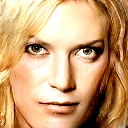

In [4]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random_normal([latent_dim], seed=3)
    v2 = tf.random_normal([latent_dim], seed=5)
    
    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

# Finding closest vector in latent space
Depending on the value of image_from_module_space, we will initialize with a random vector from the latent space, or with an image located at image_path


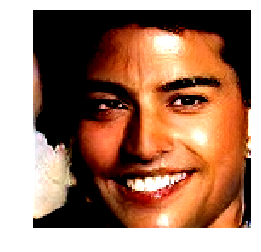

In [9]:
image_from_module_space = True

image_path = 'targets/chris.JPG'

def get_module_space_image():
    with tf.Graph().as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        vector = tf.random_normal([1,latent_dim], seed=1)
        images = module(vector)
        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            image_out = session.run(images)[0]
        return image_out
    
def load_image():
    image = imageio.imread(image_path)
    return transform.resize(image,[128,128])

if image_from_module_space:
    target_image = get_module_space_image()
else:
    target_image = load_image()
    
display_image(target_image)    
    
    
        

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

In [16]:
def find_closest_latent_vector(num_optimization_steps):
    images=[]
    losses=[]
    with tf.Graph().as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        
        initial_vector = tf.random_normal([1,latent_dim],seed=3)
        vector = tf.get_variable("vector",initializer=initial_vector)
        image = module(vector)
        
        target_image_difference = tf.reduce_sum(
            tf.losses.absolute_difference(image[0],target_image[:,:,:3]))
        
        # We get more realistic images if we regularize the length of the 
        # latent vector to the average length of vectors from this distribution
        
        regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
        
        loss = target_image_difference + regularizer
        
        optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
        train = optimizer.minimize(loss)
        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            for _ in range(num_optimization_steps):
                _, loss_out, im_out = session.run([train, loss, image])
                images.append(im_out[0])
                losses.append(loss_out)
                print (loss_out)
            return images, losses
        
result = find_closest_latent_vector(num_optimization_steps = 10)
display_images(result[0], [("Loss: %.2f" % loss) for loss in result[1]])    
        
        

0.70890707
5.8959303
5.2942257
2.907552
0.8828394
1.6446643
0.9498954
1.2747777
1.6182786
0.9285555
